In [1]:
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec

In [2]:
#import relevant data
with_time = True
if with_time:
    control_data = pd.read_csv("../cleaned_data/control_w_time.csv", index_col = 0)
    case_data = pd.read_csv("../cleaned_data/case_w_time.csv", index_col = 0)
    all_events = pd.read_csv("../cleaned_data/events_id_w_time.csv", index_col = 0)
    word2vec_model = Word2Vec.load("../word2vec_model/w2vmodel_wt")
    
    control_demo = pd.read_csv("../cleaned_data/control_demo_wt.csv", index_col = 0)
    case_demo = pd.read_csv("../cleaned_data/case_demo_wt.csv", index_col = 0)
else:
    control_data = pd.read_csv("../cleaned_data/control.csv", index_col = 0)
    case_data = pd.read_csv("../cleaned_data/case.csv", index_col = 0)
    all_events = pd.read_csv("../cleaned_data/events_id.csv", index_col = 0)
    word2vec_model = Word2Vec.load("../word2vec_model/w2vmodel")
    
    control_demo = pd.read_csv("../cleaned_data/control_demo.csv", index_col = 0)
    case_demo = pd.read_csv("../cleaned_data/case_demo.csv", index_col = 0)

In [3]:
control_demo.head()

,subject_id,gender,AGE,AMERICAN INDIAN/ALASKA NATIVE,ASIAN,BLACK/AFRICAN AMERICAN,HISPANIC/LATINO,OTHER,UNABLE TO OBTAIN,UNKNOWN,WHITE
328,10019992,0,44,0,0,0,0,0,0,0,1
1435,10078892,0,37,0,0,0,0,0,0,0,1
2448,10114736,0,49,0,0,0,0,0,0,0,1
4073,10182430,0,39,0,0,1,0,0,0,0,0
4074,10182430,0,39,0,0,0,0,1,0,0,0


In [4]:
#construct an input list of arrays with event index (start from 1)
control_temp = control_data.groupby("subject_id").apply(lambda x: x.eve_index.values)
case_temp = case_data.groupby("subject_id").apply(lambda x: x.eve_index.values)

control_temp = control_temp.sort_index()
case_temp = case_temp.sort_index()

In [5]:
control_patients = control_temp.index.values
case_patients = case_temp.index.values
all_patients = np.concatenate([control_patients,case_patients])

In [6]:
#construct labels
Y_control = np.zeros(len(control_patients))
Y_case = np.ones(len(case_patients))
Y = np.concatenate([Y_control,Y_case])

In [7]:
#set up demographic input layer 
#group by operation automatic sorts the subject id so demographic data is in the same order as events data)
X_demo_control = control_demo.sort_values(by="subject_id")
X_demo_case = case_demo.sort_values(by="subject_id")
X_demo = np.concatenate([X_demo_control.iloc[:,1:3].values ,X_demo_case.iloc[:,1:3].values])

In [8]:
#find maximum number of events(used for set the parameters of embedding layer
#all sequences of events are padded to the max length)
c_max = control_data.groupby("subject_id")["eve_index"].count().max()
ca_max = case_data.groupby("subject_id")["eve_index"].count().max()
max_num_event_patient = np.max([c_max,ca_max])

In [9]:
#contruct training set of sequences with paddings, so all the sequence has the same length of max_length, 
#with 0s padded before in shorter sequences
np.random.seed(seed=6250)
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_control = [np.array(events).astype("int") for events in control_temp]
X_case = [np.array(events).astype("int") for events in case_temp]
X_all = np.concatenate([X_control,X_case])

X = pad_sequences(X_all, maxlen=None)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
X

array([[    0,     0,     0, ..., 35322, 30848, 31782],
       [    0,     0,     0, ..., 29340,   114, 29340],
       [    0,     0,     0, ..., 32824, 34157, 33014],
       ...,
       [    0,     0,     0, ..., 32170, 32170, 36806],
       [    0,     0,     0, ..., 12585, 20475, 36807],
       [    0,     0,     0, ..., 30594, 35881, 36807]], dtype=int32)

In [11]:
print(X[0].shape[0])
print (X.shape)
print (Y.shape)

842
(438, 842)
(438,)


In [12]:
#shuffle
shuffled_index = np.random.permutation(len(all_patients))

#split train, dev, test set 7:1:2
train_index = shuffled_index[:int(len(all_patients)*0.7)]
dev_index =  shuffled_index[int(len(all_patients)*0.7):int(len(all_patients)*0.8)]
test_index =  shuffled_index[int(len(all_patients)*0.8):]

In [13]:
print (shuffled_index.shape)
print (train_index.shape, dev_index.shape, test_index.shape)

(438,)
(306,) (44,) (88,)


In [14]:
all_patients_shuffle = all_patients[shuffled_index]

Y_train = Y[train_index]
Y_dev = Y[dev_index]
Y_test = Y[test_index]

X_train = X[train_index]
X_dev = X[dev_index]
X_test = X[test_index]

X_demo_train = X_demo[train_index]
X_demo_dev = X_demo[dev_index]
X_demo_test = X_demo[test_index]

In [15]:
#contruct embedding matrix dim of (number of different events, dim of embedding)
num_events = len(all_events)
print(num_events)

36769


In [16]:
dim_embedding = len(word2vec_model.wv["1"])

In [17]:
print(dim_embedding)

100


In [18]:
#contruct embedding matrix dim of (number of different events, dim of embedding)
num_events = len(all_events)
dim_embedding = len(word2vec_model.wv["1"])
#adding the dummy row for padding at index "0"
embedding_matrix = np.zeros((num_events+1, dim_embedding))
for i in range(1, num_events):
    embedding_matrix[i] = word2vec_model.wv[i]

In [19]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.65899014, -0.31489101, -0.03198135, ..., -0.31628633,
         0.01713326,  0.02221249],
       [-0.50833392, -0.14767984,  0.01217468, ...,  0.00226545,
         0.09520426,  0.18843877],
       ...,
       [-0.20115116,  0.04379302,  0.00378813, ..., -0.03426295,
         0.24104443, -0.08053544],
       [-0.28696933, -0.1629563 , -0.1262079 , ..., -0.01282212,
         0.19591483, -0.04550172],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
#set up the model
from keras.layers import Conv1D, Dense, Input,GlobalMaxPooling1D, MaxPooling1D, concatenate, Embedding,BatchNormalization, Dropout
from keras.optimizers import SGD, Adam, RMSprop,Nadam
from keras.models import Model
from keras.models import load_model
from keras.initializers import glorot_normal

input_events = Input(shape=(max_num_event_patient,))
init = glorot_normal(seed = 6250)

#embedding layer
embedding_raw = Embedding(40000, dim_embedding,embeddings_initializer = init, input_length=max_num_event_patient)(input_events)
embedding = BatchNormalization()(embedding_raw)
#1D conv
# filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
#padding: One of "valid", "same" or "causal" (case-insensitive). "valid" means no padding. 
#"same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
#"causal" results in causal (dilated) convolutions
# activation: Activation function to use. If you don't specify anything, no activation is applied
x_2 = Conv1D(filters = 4, kernel_size = 2,padding = "valid", activation='relu')(embedding)
x_3 = Conv1D(filters = 4, kernel_size = 3,padding = "valid", activation='relu')(embedding)
x_4 = Conv1D(filters = 4, kernel_size = 4,padding = "valid", activation='relu')(embedding)
x_5 = Conv1D(filters = 4, kernel_size = 5,padding = "valid", activation='relu')(embedding)

pool_2 = GlobalMaxPooling1D()(x_2)
pool_3 = GlobalMaxPooling1D()(x_3)
pool_4 = GlobalMaxPooling1D()(x_4)
pool_5 = GlobalMaxPooling1D()(x_5)

#need to adjust the shape for demographics if demo feature changes
#now its age, sex (tried ethnicity(one hot dim = 5) but not working well)

input_demo = Input(shape=(2,))

#concatenate max_pooling results
patient_embed = concatenate([input_demo,pool_2, pool_3,pool_4,pool_5])

#fully connected part
dense1 = Dense(6, activation = "relu")(patient_embed)
dense1 = Dropout(0.2)(dense1)
output = Dense(1, activation = "sigmoid" )(dense1)

model = Model(inputs=[input_events, input_demo], outputs=output)
model.compile(optimizer=Nadam(lr = 0.0005),loss='binary_crossentropy',metrics=['accuracy'])

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [21]:
model.fit([X_train, X_demo_train],Y_train, epochs=100,batch_size =64,shuffle=True,validation_data=([X_dev, X_demo_dev], Y_dev))

Epoch 1/100
5/5 [==============================] - 4s 352ms/step - loss: 0.6614 - accuracy: 0.6438 - val_loss: 0.6482 - val_accuracy: 0.7045
Epoch 2/100
5/5 [==============================] - 1s 291ms/step - loss: 0.5338 - accuracy: 0.6438 - val_loss: 0.6457 - val_accuracy: 0.7045
Epoch 3/100
5/5 [==============================] - 2s 379ms/step - loss: 0.4951 - accuracy: 0.6438 - val_loss: 0.6428 - val_accuracy: 0.7045
Epoch 4/100
5/5 [==============================] - 2s 350ms/step - loss: 0.4564 - accuracy: 0.6438 - val_loss: 0.6393 - val_accuracy: 0.7045
Epoch 5/100
5/5 [==============================] - 2s 370ms/step - loss: 0.4229 - accuracy: 0.7320 - val_loss: 0.6386 - val_accuracy: 0.7045
Epoch 6/100
5/5 [==============================] - 2s 316ms/step - loss: 0.3911 - accuracy: 0.7908 - val_loss: 0.6372 - val_accuracy: 0.7045
Epoch 7/100
5/5 [==============================] - 2s 355ms/step - loss: 0.3807 - accuracy: 0.8137 - val_loss: 0.6351 - val_accuracy: 0.7045
Epoch 8/100
5

Epoch 59/100
5/5 [==============================] - 1s 240ms/step - loss: 0.2527 - accuracy: 0.9608 - val_loss: 0.5805 - val_accuracy: 0.7273
Epoch 60/100
5/5 [==============================] - 1s 240ms/step - loss: 0.2342 - accuracy: 0.9837 - val_loss: 0.5772 - val_accuracy: 0.7273
Epoch 61/100
5/5 [==============================] - 1s 246ms/step - loss: 0.2495 - accuracy: 0.9673 - val_loss: 0.5744 - val_accuracy: 0.7273
Epoch 62/100
5/5 [==============================] - 1s 238ms/step - loss: 0.2410 - accuracy: 0.9739 - val_loss: 0.5749 - val_accuracy: 0.7273
Epoch 63/100
5/5 [==============================] - 2s 331ms/step - loss: 0.2366 - accuracy: 0.9804 - val_loss: 0.5738 - val_accuracy: 0.7273
Epoch 64/100
5/5 [==============================] - 2s 362ms/step - loss: 0.2580 - accuracy: 0.9477 - val_loss: 0.5721 - val_accuracy: 0.7273
Epoch 65/100
5/5 [==============================] - 1s 245ms/step - loss: 0.2398 - accuracy: 0.9739 - val_loss: 0.5694 - val_accuracy: 0.7273
Epoch 

In [22]:
model.save('cnn-model.h5')

In [23]:
model.evaluate([X_test, X_demo_test], Y_test)

3/3 [==============================] - 0s 30ms/step - loss: 0.5001 - accuracy: 0.7386


[0.5000914931297302, 0.7386363744735718]

In [24]:
from sklearn import metrics
print(metrics.roc_auc_score(Y_test, model.predict([X_test, X_demo_test])))

3/3 [==============================] - 0s 19ms/step
0.8118489583333334


In [25]:
#Visualize patient representation trained by CNN

In [26]:
#get embedding
patient_embedding=Model(inputs=[input_events, input_demo], outputs=patient_embed).predict([X, X_demo[0:438]])

14/14 [==============================] - 0s 22ms/step


In [27]:
patient_embedding.shape

(438, 18)

In [28]:
from sklearn.manifold import TSNE
from time import time

In [ ]:
# Convolutional Neural Network learn form this 
# https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/4.%20Convolutional%20Neural%20Networks/4.1%20Convolutional%20Neural%20Networks.ipynb

Computing t-SNE embedding
t-SNE: 5.5 sec


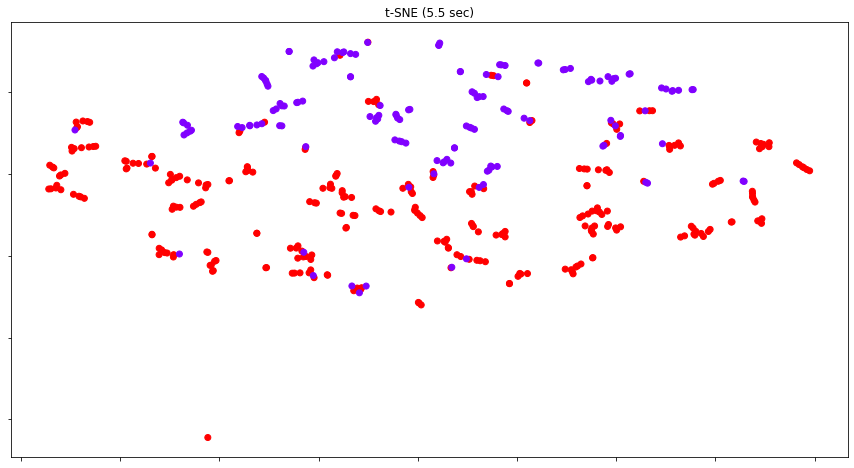

In [46]:
#use t-sne to visualize patient representations in control group and case group
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, perplexity =2,init='pca', random_state=0,method='exact')
t0 = time()
patient_tsne = tsne.fit_transform(patient_embedding)

t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn.utils import check_random_state

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1,1,1)
plt.scatter(patient_tsne[:,0], patient_tsne[:,1], c=Y,cmap=plt.cm.rainbow_r)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [30]:
#Doing Kmeans upon learned feature embeddings

In [31]:
#get case embeddings
case_embedding = patient_embedding[Y==1]

In [32]:
case_embedding.shape

(146, 18)

In [33]:
from sklearn.cluster import KMeans
%matplotlib inline 

In [ ]:
# T-distributed Stochastic Neighbor Embedding to visualize the patient representations by CNN pooling layer
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# K-Means clustering to show clustered the representation from case patients  
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [34]:
kmeans_wss=[]
kmeans_idx=[]
for i in range(2,20):

    kmeans_clustering = KMeans( n_clusters = i).fit(case_embedding)
    kmeans_idx.append(kmeans_clustering.labels_)
    kmeans_wss.append(kmeans_clustering.inertia_)

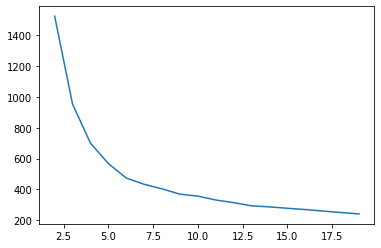

In [35]:
#find good # of clusters 
plt.plot(range(2,20), kmeans_wss)

In [36]:
#Visualize 3 clusters in case group using pateint representation

In [123]:
case_class = KMeans(n_clusters = 5).fit(case_embedding).labels_ +1

Computing t-SNE embedding
t-SNE: 1.6 sec


Text(0.5, 1.0, 't-SNE: 1.6 sec')

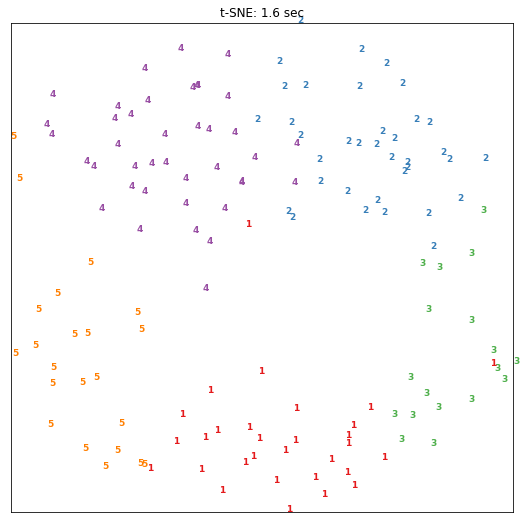

In [130]:
#visualize and tag tsne graph using kmeans result 
print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, perplexity =13.7,init='pca', learning_rate=500,early_exaggeration=2.0,random_state=6250,method='exact')  
t0 = time()
case_tsne = tsne.fit_transform(case_embedding)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
x_min, x_max = np.min(case_tsne, 0), np.max(case_tsne, 0)
case_tsne = (case_tsne - x_min) / (x_max - x_min)

plt.figure(figsize=(9,9))
ax = plt.subplot(111)
for i in range(case_tsne.shape[0]):
    plt.text(case_tsne[i, 0], case_tsne[i, 1], str(case_class[i]),
                color=plt.cm.Set1(case_class[i]/10.0),
                fontdict={'weight': 'bold', 'size': 9})

plt.xticks([]), plt.yticks([])
plt.title("t-SNE: %.2g sec" % (t1 - t0))

In [131]:
#TopK n-gram in Each Cluster

In [132]:
from nltk import ngrams
import operator

def topk(X_case, case_class, cluster,k,n):
    codes_class=[]
    d={}
    for i in np.where(case_class==cluster)[0]:
        codes_class += list(ngrams(X_case[i],n))
    for e in codes_class:
        d[e] = d.get(e,0)+1
    d2 = {k: v/float(sum(d.values())) for (k,v) in d.items()}

    sorted_code = sorted(d2.items(), key=operator.itemgetter(1),reverse=True)

    return [x[0] for x in sorted_code[:k]]

In [133]:
event_id_dict = dict(zip(all_events.eve_index,all_events.events))

In [134]:
def top_grams(event_pairs):
    return [tuple(event_id_dict[x] for x in tup) for (i,tup) in enumerate(event_pairs)]

In [136]:
import pprint
pp = pprint.PrettyPrinter()
for c in range(1,6):
    pp.pprint('cluster:' + str(c))
    onegram = topk(X_case,case_class,c,10,1)
    twogram = topk(X_case,case_class,c,10,2)
    threegram = topk(X_case,case_class,c,10,3)
    pp.pprint(top_grams(onegram))
    pp.pprint(top_grams(twogram))
    pp.pprint(top_grams(threegram))
    print("")
    print("")

'cluster:1'
[('acetaminophen',),
 ('docusate sodium',),
 ('sodium chloride 0.9%  flush',),
 ('ibuprofen',),
 ('lactated ringers',),
 ('bisacodyl',),
 ('simethicone',),
 ('milk of magnesia',),
 ('ondansetron',),
 ('calcium carbonate',)]
[('acetaminophen', 'docusate sodium'),
 ('milk of magnesia', 'bisacodyl'),
 ('docusate sodium', 'calcium carbonate'),
 ('calcium carbonate', 'milk of magnesia'),
 ('lactated ringers', 'simethicone'),
 ('bisacodyl', 'ibuprofen'),
 ('sodium chloride 0.9%  flush', 'acetaminophen'),
 ('sodium chloride 0.9%  flush', 'oxycodone (immediate release)'),
 ('acetaminophen', 'acetaminophen'),
 ('ibuprofen', 'lactated ringers')]
[('docusate sodium', 'calcium carbonate', 'milk of magnesia'),
 ('calcium carbonate', 'milk of magnesia', 'bisacodyl'),
 ('acetaminophen', 'docusate sodium', 'calcium carbonate'),
 ('milk of magnesia', 'bisacodyl', 'ibuprofen'),
 ('sodium chloride 0.9%  flush', 'acetaminophen', 'docusate sodium'),
 ('ibuprofen', 'lactated ringers', 'simethico

In [137]:
#model2 = Model(inputs = input_events_r,outputs = x_2_r)
model2 = Model(inputs = input_events,outputs = x_2)
model3 = Model(inputs = input_events,outputs = x_3)
model4 = Model(inputs = input_events,outputs = x_4)

In [138]:
model2.predict(X).shape

14/14 [==============================] - 0s 8ms/step


(438, 477, 4)

In [139]:
#the temperal dimention of output size is max_events - n 
patient_feature_weights2 = model2.predict(X).reshape(4, 438, 841)
patient_feature_weights3 = model3.predict(X).reshape(4, 438, 840)
patient_feature_weights4 = model4.predict(X).reshape(4, 438, 839)

14/14 [==============================] - 0s 9ms/step


ValueError: cannot reshape array of size 835704 into shape (4,438,841)

In [140]:
def get_top_events(filter_output, top_num = 500, filter_size = 2):
    top = filter_output.flatten().argsort()[-top_num:]
    
    top_feature_med = []
    top_feature_diag = []
    top_feature_proc = []
    
    event_width = filter_output.shape[1]
    for idx in top:
        patient_idx = int(np.floor(idx/event_width))
        event_idx =  idx%event_width
        real_patient_id = all_patients_shuffle[patient_idx]
        real_event_id = X[patient_idx,event_idx:event_idx+2]
        if np.sum(real_event_id) !=0:
            for eve in real_event_id:
                print(eve)
                if eve >= 16120:
                    top_feature_med.append(eve)
                elif eve < 16120 and eve >= 9440:
                    top_feature_proc.append(eve)
                elif eve < 9440 and eve > 0:
                    top_feature_diag.append(eve)
                
    top_counts_med = pd.Series(top_feature_med).value_counts()
    top_counts_diag = pd.Series(top_feature_diag).value_counts()
    top_counts_proc = pd.Series(top_feature_proc,dtype='float64').value_counts()
    
    top_counts_med = pd.DataFrame({"index": top_counts_med.index, "counts":top_counts_med})
    top_counts_diag = pd.DataFrame({"index": top_counts_diag.index, "counts":top_counts_diag})
    top_counts_proc = pd.DataFrame({"index": top_counts_proc.index, "counts":top_counts_proc})
    
    return top_counts_med, top_counts_diag, top_counts_proc

In [141]:
eve_list_med = []
eve_list_diag = []
eve_list_proc = []
for i in range(4):
    te2_med, te2_diag, te2_proc = get_top_events(patient_feature_weights2[i])
    te3_med, te3_diag, te3_proc = get_top_events(patient_feature_weights3[i])
    te4_med, te4_diag, te4_proc = get_top_events(patient_feature_weights4[i])
    
    eve_list_med.append(te2_med)
    eve_list_med.append(te3_med)
    eve_list_med.append(te4_med)
    
    eve_list_diag.append(te2_diag)
    eve_list_diag.append(te3_diag)
    eve_list_diag.append(te4_diag)
    
    eve_list_proc.append(te2_proc)
    eve_list_proc.append(te3_proc)
    eve_list_proc.append(te4_proc)

29329
30848
26061
26541
32006
29794
29535
30261
32075
32075
14877
15772
33585
34642
35452
32006
33133
29379
35388
35388
28623
28623
5581
35454
15151
405
36021
36021
36021
36021
33355
35452
30261
32075
4186
4655
35986
35986
35454
35454
34642
34642
34915
32170
26406
26406
32409
31853
31747
31747
34253
28623
35454
35454
4698
5264
35454
35454
32609
32609
30848
30848
32159
32159
34253
28623
31853
31959
28801
32609
2315
157
6643
5676
6759
3009
5146
5206
5695
5695
3681
19433
34017
33515
35322
35454
35454
28378
15533
35388
35388
18872
28623
35452
35452
30800
31853
0
12581
10937
27506
5572
35454
34324
34324
32799
30689
31853
31853
34324
34324
1774
1774
34324
36021
5695
6633
2700
2980
27939
27888
33424
29535
4899
4878
5937
5402
35881
35881
5691
5691
32609
32609
32609
35388
29794
29794
30722
35881
4186
4186
32609
34261
32609
34632
32554
28939
19393
28623
1013
27888
3681
1013
32554
32554
32409
31594
6633
6699
5504
8796
32609
31853
30848
30848
17947
35454
19394
27940
32609
35568
2336
26197
5146
588

In [142]:
final_top_proc["events"].apply(lambda x: x[-3:]).values

array(['419', '669', '329', '876', '210', '200', '909', '785', '733',
       '119', '798', '860', '495', '010', '129', '671', '039', '859',
       '649', '909', '936', '621', '700', '918', 'G35', '322', '429',
       '929', '181', '582', '532', 'F39', '491', '031', '609', '300',
       '868', '581', '959', 'J36', '219', '284', '353', '900', '720',
       '290', '332', '319', '951', '952', '954', '966', '251', '252',
       '509', '638', 'D65', '696', '011', '749', '282', '639', '147',
       '872', '782', '786', '788', '890', '011', '123', '259', '288',
       'B21', '490', 'F29', '760'], dtype=object)

In [143]:
eve_counts_d = pd.concat(eve_list_diag, axis = 0).groupby("index").sum().sort_values(by = "counts", ascending = False)[:]
final_top_diag = eve_counts_d.merge(all_events, how = "left", left_index = True, right_on = "eve_index")

eve_counts_p = pd.concat(eve_list_proc, axis = 0).groupby("index").sum().sort_values(by = "counts", ascending = False)[:]
final_top_proc = eve_counts_p.merge(all_events, how = "left", left_index = True, right_on = "eve_index")

eve_counts_m = pd.concat(eve_list_med, axis = 0).groupby("index").sum().sort_values(by = "counts", ascending = False)[:]
final_top_med = eve_counts_m.merge(all_events, how = "left", left_index = True, right_on = "eve_index")

In [144]:
final_top_diag 

,counts,events,eve_index
111,14,0.9% sodium chloride,112
5694,5,66411,5695
4185,3,470,4186
3008,3,34690,3009
3680,2,3E0,3681
6972,2,756,6973
6632,2,734,6633
5690,2,664,5691
5145,2,6146,5146
2465,2,29680,2466


In [145]:
final_top_med

,counts,events,eve_index
35453,18,sodium chloride 0.9% flush,35454
32608,16,lactated ringers,32609
31852,12,heparin,31853
34156,10,ondansetron,34157
30847,9,docusate sodium,30848
...,...,...,...
28379,1,Z87898,28380
28377,1,Z87891,28378
28190,1,Z7901,28191
28189,1,Z781,28190


In [146]:
final_top_output = pd.DataFrame({"Med": final_top_med["events"].values[0:10]
                                 ,"Diag": final_top_diag["events"].apply(lambda x: x[-3:]).values[0:10]
                                 ,"Proc":final_top_proc["events"].apply(lambda x: x[-3:]).values[0:10]})


In [147]:
final_top_output

,Med,Diag,Proc
0,sodium chloride 0.9% flush,ide,620
1,lactated ringers,411,909
2,heparin,470,660
3,ondansetron,690,289
4,docusate sodium,3E0,219
5,potassium chloride,756,948
6,acetaminophen,734,390
7,insulin,664,789
8,simethicone,146,770
9,magnesium sulfate,680,918
